# Maps in Cartopy

***

You will need to do the following in your terminal before you can run the code in this notebook:

   1. Install the necessary python libraries (if not already installed)
   
```bash
$ conda update conda

$ conda install xarray dask netCDF4 bottleneck

$ conda install -c conda-forge cartopy shapely cmocean
```

   2. Download and extract [ETOPO1](https://www.ngdc.noaa.gov/mgg/global) global topography

```bash
$ cd /path/to/data

$ wget https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/netcdf/ETOPO1_Bed_g_gmt4.grd.gz

$ gunzip ETOPO1_Bed_g_gmt4.grd.gz
```

   3. Download `LambertConformalTicks.py` workaround code from B. Moore-Maley [Bitbucket](https://bitbucket.org/salishsea/analysis-ben/src/default/modules/LambertConformalTicks.py) page (based on code from Github user [ajdawson](https://gist.github.com/ajdawson/dd536f786741e987ae4e))

```bash
$ cd /path/to/pythonpath

$ wget https://bitbucket.org/salishsea/analysis-ben/raw/tip/modules/LambertConformalTicks.py
```

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm

import LambertConformalTicks as lct

%matplotlib inline

Load ETOPO1 dataset as netCDF

In [2]:
# Load ETOPO1 as netCDF
topo = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/bathymetry/ETOPO1_Bed_g_gmt4.grd')

### Lambert example
Probably needed for larger maps. Requires `LambertConformalTicks.py` workaround since `Cartopy` currently only supports ticklabels for Mercator and PlateCarree projections.

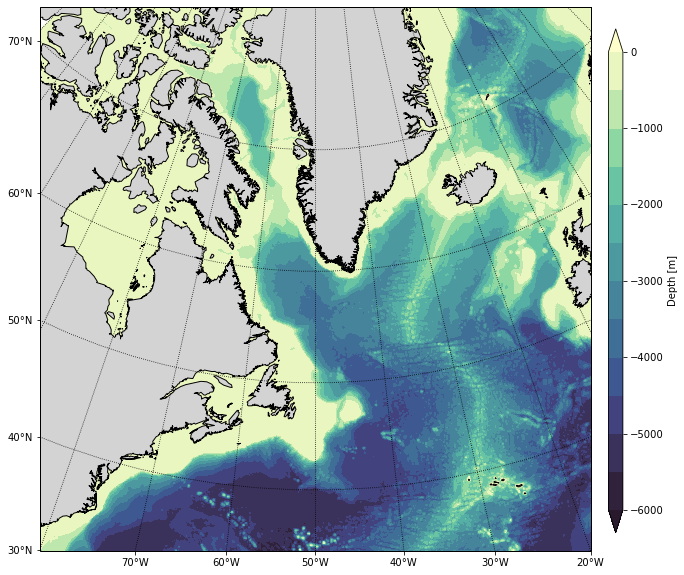

In [6]:
# Define plotting boundaries
xbound, ybound = [-80, -20], [30, 79] # Sets the projection extent
xlim, ylim = [-120, 30], [30, 90]     # Sets the gridline and bathymetry extent (needs to be larger because of conic)

# Make projection and coastlines
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.LambertConformal(np.mean(xbound), np.mean(ybound))})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ax.set_extent(xbound + ybound)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='lightgray'))
fig.canvas.draw()

# Add bathymetry (interpolate to 0.1 deg to reduce plotting resolution)
topo_labsea = topo.interp(x=np.arange(*xlim, 0.1), y=np.arange(*ylim, 0.1))
lon, lat, depth = [topo_labsea[var].values for var in ['x', 'y', 'z']]
c = ax.contourf(lon, lat, depth, levels=range(-6000, 1, 500), cmap=cm.deep_r, extend='both', transform=crs.PlateCarree())

# Add gridlines, ticks and colorbar
xticks, yticks = [list(range(*l, 10)) for l in [xlim, ylim]]
ax.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lct.lambert_xticks(ax, xticks)
lct.lambert_yticks(ax, yticks)
fig.colorbar(c, cax=cax, label='Depth [m]')

plt.show()

### Mercator example
Suitable for smaller maps. No ticklabel hack required. Full resolution GSHHS will be slower.

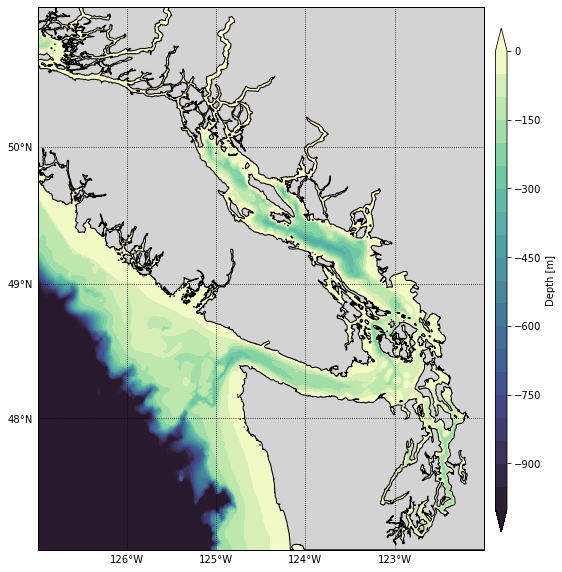

In [12]:
# Make projection and coastlines
xlim, ylim = [-127, -122], [47, 51]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='lightgray'))

# Add bathymetry (use full resolution for Salish Sea)
topo_salish = topo.sel(x=slice(*xlim), y=slice(*ylim))
lon, lat, depth = [topo_salish[var].values for var in ['x', 'y', 'z']]
c = ax.contourf(lon, lat, depth, levels=range(-1000, 1, 50), cmap=cm.deep_r, extend='both', transform=crs.PlateCarree())

# Add gridlines, ticks and colobar
xticks, yticks = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xticks, ylocs=yticks)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False
fig.colorbar(c, cax=cax, label='Depth [m]')

plt.show()